# Módulo 1

## Aula 1

### Tratamento dos dados

Vamos começar importando as bibliotecas usuais. Além delas, vamos usar também a biblioteca menos conhecida *pyjanitor*, que acrescenta aos *DataFrames* do *pandas* uma série de métodos que tornam sua manipulação mais fácil. A opção *display.float_format* torna os números mostrados pelo *pandas* mais legíveis.

In [1]:
from pathlib import Path

import janitor
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

pd.set_option('display.float_format', lambda n: f'{n:.2f}')

arquivo = Path('../dados/gastos_por_uf.csv')

Ao ler o arquivo *csv*, precisamos nos atentar para alguns detalhes:
* Seu separador (*sep*) é o *;* (ponto-e-vírgula).
* Como o arquivo vem tanto com um cabeçalho quanto com um rodapé, precisamos avisar o *pandas* para pular essas linhas (*skiprows* para o cabeçalho e *skipfooter* para o rodapé).
* A opção *thousands* define o separador de milhares enquanto que *decimal* define o separador decimal.
* Segundo o site da TabNet, dados numéricos iguais a *0* que não são resultantes de arredondamento são representados por um *-* (hífen). Essa terminologia é ambígua, mas nós vamos tratar os hífens como sendo valores ausentes (*NaN*), usando o parâmetro *na_values*.

Além disso, fazemos mais alguns processamentos para facilitar a manipulação dos dados:
* O método *clean_names* (*pyjanitor*) retira os acentos, espaços e barras (*/*) dos nomes, assim como torna todas as letras minúsculas, para facilidade de uso.
* Renomeanos a coluna de *Unidade da Federação* para apenas *unidade*.
* O método *transform_columns* (*pyjanitor*) é usado para retirar os números que aparecem antes do nome de cada estado.

In [2]:
dados = (
    pd.read_csv(
        arquivo,
        sep=';',
        skiprows=2,
        skipfooter=15,
        thousands='.',
        decimal=',',
        na_values='-',
    )
    .clean_names()
    .rename(columns={'unidade_da_federacao': 'unidade'})
)

Os nomes da unidades da federação são todos precedidos por números. Ao inspecionar esses números com cuidado, vemos que o primeiro dígito refere-se à região a que a unidade pertence. Tendo isso em mente, nós vamos

* Criar uma nova coluna chamada *regiao*, que contém os códigos das regiões (*assign*).
* Definí-la como a primeira coluna do *DataFrame* (*reorder_columns*, *pyjanitor*).
* Substituir os números pelas siglas das regiões (*find_replace*, *pyjanitor*).
* Tornar a coluna *regiao* do tipo *categórico* (esse passo não é necessário, mas ajuda na organização) (*encode_categorical*, *pyjanitor*).
* Apagar os códigos da coluna *unidade* (*assign*).

In [3]:
dados = (
    dados.assign(regiao=dados['unidade'].str[0])
    .reorder_columns(['regiao']) # Coloca a coluna 'regiao' em primeiro lugar.
    .find_replace(regiao={'1': 'N', '2': 'NE', '3': 'SE', '4': 'S', '5': 'CO'})
    .encode_categorical('regiao')
    .assign(unidade=dados['unidade'].str[3:])
)

dados.head()

,regiao,unidade,2008_jan,2008_fev,2008_mar,2008_abr,2008_mai,2008_jun,2008_jul,2008_ago,...,2019_dez,2020_jan,2020_fev,2020_mar,2020_abr,2020_mai,2020_jun,2020_jul,2020_ago,total
0,N,Rondônia,1388528.39,2931283.42,1541682.52,1525314.96,1645953.84,1406150.68,3065279.01,3231494.61,...,8085025.66,9221412.18,7493310.88,8092260.11,7273843.63,7652120.28,8725530.68,11152107.08,10285455.78,929129659.72
1,N,Acre,902416.00,1497206.26,1794028.48,1730469.42,1819443.92,1828496.00,2511754.59,2089107.14,...,2874871.28,3331803.55,3417691.07,3076003.20,2286642.60,2896340.24,3045245.80,3915193.20,nan,420668039.63
2,N,Amazonas,4735529.42,7118990.57,8196635.49,8259378.42,7831399.90,8477273.62,9368858.72,9352532.70,...,14346553.60,16018459.07,14913745.37,15068304.35,13509579.29,19658585.46,20897542.93,19346450.18,14726443.67,1771654871.23
3,N,Roraima,657889.53,777939.31,718688.03,839994.39,862347.96,832440.66,996693.09,894271.18,...,3097113.21,3059823.80,2912519.98,2937346.43,2868820.96,2752228.26,3401864.29,3015488.30,2826486.18,305010883.18
4,N,Pará,18864744.11,19553758.20,21937342.70,20842829.69,23249952.88,23240687.56,24002223.56,23341218.03,...,35925899.01,34345207.63,37384336.94,35512568.15,28217249.66,32617541.05,41625331.28,38438873.79,39911193.02,4437115730.71


Para facilitar as análises, vamos realizar mais algumas modifições nos dados:
* Primeiramente, criamos um novo *DataFrame* chamado *totais* que contém apenas a coluna dos valores totais do período para cada estado.
* Usando a função *pd.melt* vamos criar um novo *DataFrame* que contém os mesmos dados, mas na forma longa. Isto significa que *dados_longo* terá as colunas *regiao*, *unidade*, *periodo*, e *gasto*. Na sequencia,
    * o método *deconcatenate_columns* do *pyjanitor* separa anos e meses em duas colunas a parte;
    * convertemos a coluna _ano_ para valores numéricos (ela é inicialmente uma *string* por ter vindo dos nomes de colunas que continham mês e ano).

In [4]:
totais = dados[['unidade', 'total']]

dados_longo = (
    pd.melt(
        dados.drop(columns=['total']),
        id_vars=['regiao', 'unidade'],
        var_name='periodo',
        value_name='gasto'
    ).deconcatenate_column(
        column_name='periodo',
        new_column_names=['ano', 'mes'],
        sep='_',
        preserve_position=True,
    ).change_type('ano', 'int16')
)

dados_longo.head()

,regiao,unidade,ano,mes,gasto
0,N,Rondônia,2008,jan,1388528.39
1,N,Acre,2008,jan,902416.00
2,N,Amazonas,2008,jan,4735529.42
3,N,Roraima,2008,jan,657889.53
4,N,Pará,2008,jan,18864744.11


Vamos analisar os valores processados para cada unidade da federação no mês de agosto de 2008, utilizando a biblioteca *matplotlib*. Para isso, vamos definir uma função que realize todo o trabalho. Depois disso, só precisamos fornecer um *DataFrame* com os valores desejados. É importante notar que a função é *ad-hoc* e não há garantia de que funcione no caso geral.

In [5]:
def barras_de_gastos(valores, mes, ano):
    fig, ax = plt.subplots(figsize=(6, 10))

    # Definindo a cor de fundo da imagem.
    fig.patch.set_facecolor('#fdf6e3')
    ax.set_facecolor('#fdf6e3')

    ax.set_title(f'Valores processados por UF\nem {mes}/{ano} (milhões de reais)')

    # Cor que vai ser utilizada para as barras.
    cor = '#2aa198'

    # O dicionário *barras* terá uma entrada para cada região. Em cada uma dessas entradas, vamos gerar um conjunto de barras para os estados correspondentes.
    barras = dict()
    regioes = ['CO', 'N', 'NE', 'S', 'SE']

    # Para lidar com os vários conjuntos de barras, precisamos saber quantos estados estão em cada região,
    # assim como os nomes dos estados, na ordem em que serão inseridos.
    num_de_estados_por_regiao = []
    nomes_dos_estados = []

    for indice, regiao in enumerate(regioes):
        # Vamos nos livrar de possíveis valores nulos e substituí-los por 0.
        valores_por_regiao = valores.query('regiao == @regiao')#.fill_empty(column_names='gasto', value=0)
        # Acrestando o número de estados da região atual.
        num_de_estados_por_regiao.append(valores_por_regiao.shape[0])

        # A posição *y* de cada barra está relacionada com o índice do laço, que dá o ponto de partida para cada região,
        # com o número total de estados das regiões anteriores (por isso o *sum*), e a posição do estado na região atual
        # (último termo).
        barras[regiao] = ax.barh(
            y=indice + sum(num_de_estados_por_regiao[:-1]) + np.arange(num_de_estados_por_regiao[-1]),
            width=valores_por_regiao['gasto'],
            color=cor,
        )

        # Aproveitamos o laço para criar uma lista com os nomes do estados, na ordem em que aparecem,
        # e com *strings* vazias separando as regiões (o motivo deve ficar claro mais abaixo).
        nomes_dos_estados += valores_por_regiao['unidade'].to_list() + ['']

    for spine in ax.spines:
        ax.spines[spine].set_visible(False)

    ax.tick_params(length=0)
    # Um limite superior maior do que o padrão garante que a etiqueta (definidas no laço abaixo) associada ao valor mais alto caiba no gráfico.
    maximo = valores['gasto'].max()
    ax.set_xlim(0, maximo*1.05)
    ax.set_xticks([])
    # É importante definir explicitamente os posições dos *ticks* desejados para podermos exibir os nomes dos estados.
    ax.set_yticks(range(32))
    # A *string* vazia na lista de nomes é conveniente para conseguirmos pular o *tick* que fica entre as regiões
    # (caso contrário, ao mudar de região os nomes ficariam defasados).
    ax.set_yticklabels(nomes_dos_estados)

    # Definimos a posição da etiqueta que exibe os valores de cada estado.
    for regiao in barras.values():
        for barra in regiao:

            largura = barra.get_width()

            ax.text(
                largura,
                # A posição vertical depende da posição da barra, *y*, e de sua "altura," *height*.
                barra.get_y() + barra.get_height()/2,
                # A visualização fica mais clara se exibirmos os valores em milhões (por isso a divisão).
                # O espaço em branco no início da *string* faz com que a etiqueta não fique colada na barra.
                f' {largura/10**6:.1f} ',
                va='center',
                ha='left',
            )

    plt.show()

### Desafio 01: Escolher um título mais descritivo, que passe a mensagem adequada ao gráfico de barras.

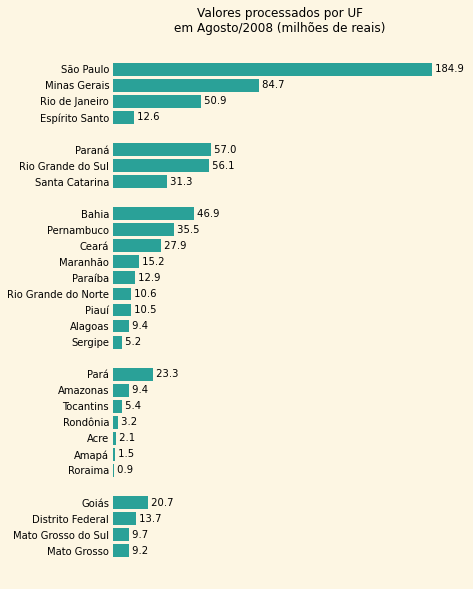

In [6]:
# Selecionando os valores relevantes e ordenando de maneira que os estados fiquem agrupados por região, e em cada região fiquem ordenados por valor.
valores = dados_longo.query('ano == 2008 & mes == "ago"').sort_values(by=['regiao', 'gasto'], na_position='first')

barras_de_gastos(valores, 'Agosto', '2008')

### Desafio 02: Faça a mesma análise realizada em aula, porém para o mês mais recente.

Vamos ver o mesmo gráfico para o último mês presente nos dados, que é Agosto de 2020.

In [7]:
dados_longo.tail()

,regiao,unidade,ano,mes,gasto
4099,S,Rio Grande do Sul,2020,ago,101374341.51
4100,CO,Mato Grosso do Sul,2020,ago,19241624.02
4101,CO,Mato Grosso,2020,ago,17790649.87
4102,CO,Goiás,2020,ago,43984702.05
4103,CO,Distrito Federal,2020,ago,26526196.39


Reutilizando a função que definimos.

posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values


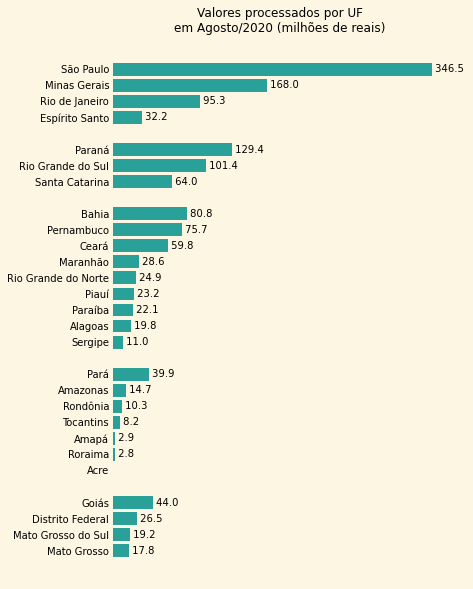

In [8]:
# Selecionando os valores relevantes e ordenando de maneira que os estados fiquem agrupados por região, e em cada região fiquem ordenados por valor.
valores = dados_longo.query('ano == 2020 & mes == "ago"').sort_values(by=['regiao', 'gasto'], na_position='first')

barras_de_gastos(valores, 'Agosto', '2020')